In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig

In the following block I have loaded a simulated spikes train and tried to get its low-pass filter as a calcium signal. the time constant here is chosen as tau=100ms.

In [2]:
spikes = np.load("spikes-10e4-ms.npy")

N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]
calcium = np.zeros((N, sim_dur))
tau = 100
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]

In [37]:
np.size(ca)

11250000

Here I have chosen neuron number 500 and added a gaussian noise of N(0,1).\
In the plot:\
greem: simulated calcium\
blue: clacium with noise\
orange: gaussian noiese\
red: spikes train

In [3]:
n = 500
calciumN = calcium[n, :]
noise = np.random.normal(0,1, sim_dur)
cn = calciumN + noise

In [4]:
np.save('noisy_cal',cn)

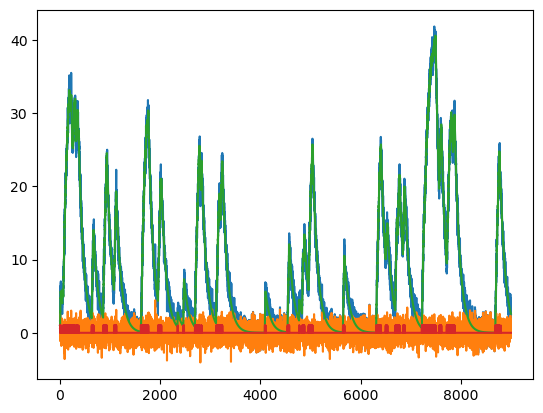

In [5]:
plt.plot(cn)
plt.plot(noise)
plt.plot(calciumN)
plt.plot(spikes[500, :])

Denoising by savitzky filter for signal and its first derivation and putting them into the exact solution of first order eq. works well. the only difference is the sign.

In [21]:
smooth_cal = sig.savgol_filter(cn, window_length=21, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(cn, window_length=21, deriv=1, delta=1., polyorder=3)

#x = np. zeros(sim_dur)
#x[0] = 0.0



x = smooth_deriv + (1/tau)*smooth_cal

In [30]:
smooth_cal = sig.savgol_filter(calciumN, window_length=5, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calciumN, window_length=5, deriv=1, delta=1., polyorder=3)

#x = np. zeros(sim_dur)
#x[0] = 0.0



x = smooth_deriv + (1/tau)*smooth_cal

In [26]:
1/tau

0.01

In [35]:
%matplotlib qt
plt.plot(smooth_cal)

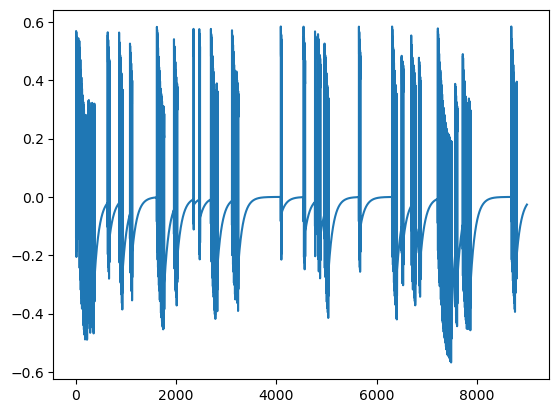

In [31]:
plt.plot(smooth_deriv)

 α ẏ(t) + β y(t)  =  x(t)

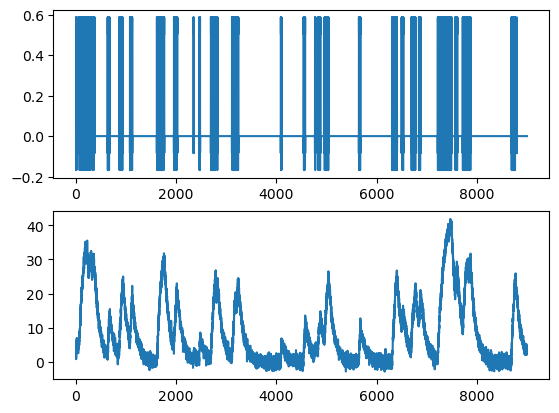

In [32]:

plt.subplot(2,1,1)
plt.plot(x)
plt.subplot(2,1,2)
plt.plot(cn)
#plt.plot(-x)

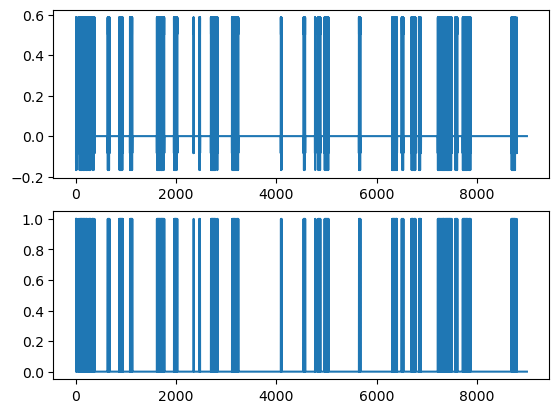

In [33]:
plt.subplot(2,1,1)
plt.plot(x)
plt.subplot(2,1,2)
plt.plot(spikes[500, :])

I was thinking the resulted denoised signal can be percieved as calcium signal which I can deconvolve it again in order to gain spikes train. But it seems it doesn't work.

In [22]:
y = np. zeros(sim_dur)
y[0] = 0.0

for i in range(0, sim_dur-1):
    #y[i+1] = x[i+1] - const_A*x[i]
    y[i] = x[i] + const_A*x[i]

In [40]:
plt.plot(x)
#plt.plot(cn)
plt.plot(y)

In [25]:
np.corrcoef(spikes[500, :], y)

array([[1.        , 0.46656714],
       [0.46656714, 1.        ]])

Correlation of spikes train and resulted signal is 53% and is 33% with calcium signal(noisy or de-noised).

In [36]:
np.corrcoef(spikes[500, :], x)

array([[1.        , 0.66361667],
       [0.66361667, 1.        ]])